## 1.2

In [1]:
import os
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.utils.data
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

In [2]:
class RK4():
    def __init__(self,t=4,x0=0,v0=0,h=0.02,x_axis=True) -> None:
        self.x0 = x0
        self.v0 = v0
        self.t = t
        self.h = h
        self.is_x = x_axis
        self.res = self.RungeKutta4()
    def f1(self,x,v,t):
        return v
    def f2(self,x,v,t):
        if self.is_x:
            return 5*np.sin((6*5*np.sqrt(0.5**2+4/4)*np.sin(np.arctan2(2*0.5,2))/2**2)*t**2)
        else:
            return 5*np.cos((6*5*np.sqrt(0.5**2+4/4)*np.sin(np.arctan2(2*0.5,2))/2**2)*t**2)
    def RungeKutta4(self):
        h = self.h
        n = int(self.t/self.h)
        V = np.zeros( n+ 1)
        T = np.zeros(n + 1)
        X = np.zeros(n + 1)
        X[0], V[0] = self.x0, self.v0
        for i in range(n):
          k1_v = h*self.f2(X[i],V[i],T[i])
          k1_x = h*self.f1(X[i],V[i],T[i])
          k2_v = h*self.f2(X[i]+0.5*k1_x,V[i]+0.5*k1_v,T[i]+0.5*h)
          k2_x = h*self.f1(X[i]+0.5*k1_x,V[i]+0.5*k1_v,T[i]+0.5*h)
          k3_v = h*self.f2(X[i]+0.5*k2_x,V[i]+0.5*k2_v,T[i]+0.5*h)
          k3_x = h*self.f1(X[i]+0.5*k2_x,V[i]+0.5*k2_v,T[i]+0.5*h)
          k4_v = h*self.f2(X[i]+k3_x,V[i]+k3_v,T[i]+h)
          k4_x = h*self.f1(X[i]+k3_x,V[i]+k3_v,T[i]+h)
          X[i+1] = X[i] + (k1_x + 2*k2_x + 2*k3_x + k4_x)/6
          V[i+1] = V[i] + (k1_v + 2*k2_v + 2*k3_v + k4_v)/6
          T[i+1] = T[i] + h
        return (T,X,V)

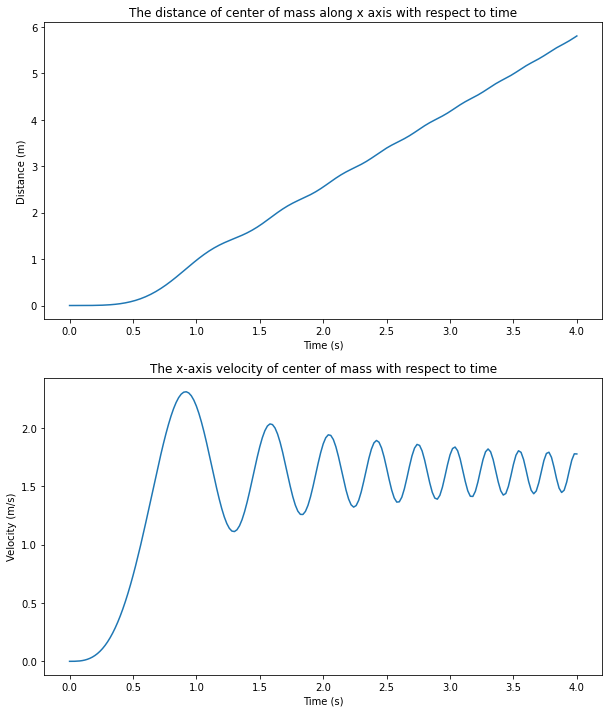

In [3]:
x_axis = RK4()
t_x, dist_x, vel_x = x_axis.res
fig, (ax1,ax2) =plt.subplots(2,1,figsize=(10,12))
ax1.plot(t_x,dist_x)
ax1.set(xlabel='Time (s)', ylabel='Distance (m)',title='The distance of center of mass along x axis with respect to time')
ax2.plot(t_x, vel_x)
ax2.set(xlabel='Time (s)', ylabel='Velocity (m/s)',title='The x-axis velocity of center of mass with respect to time')
plt.savefig("1_2_x.png")

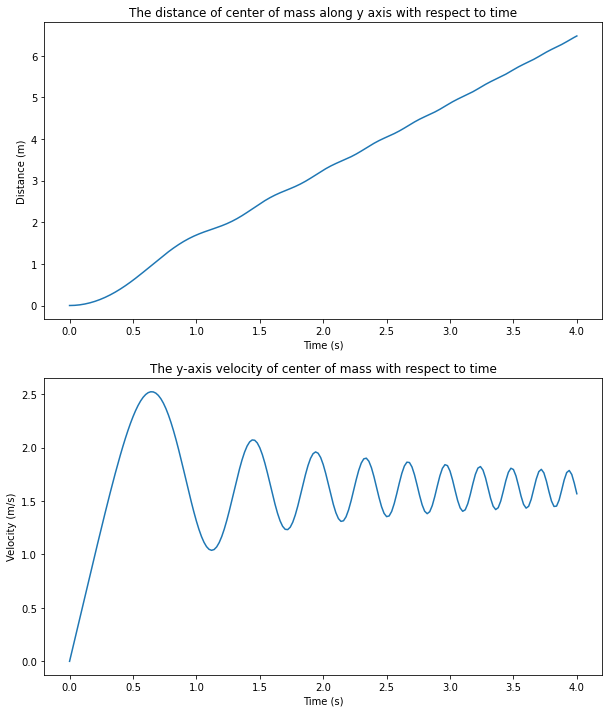

In [4]:
y_axis = RK4(x_axis=False)
t_y, dist_y, vel_y = y_axis.res
fig, (ax1,ax2) =plt.subplots(2,1,figsize=(10,12))
ax1.plot(t_y,dist_y)
ax1.set(xlabel='Time (s)', ylabel='Distance (m)',title='The distance of center of mass along y axis with respect to time')
ax2.plot(t_y, vel_y)
ax2.set(xlabel='Time (s)', ylabel='Velocity (m/s)',title='The y-axis velocity of center of mass with respect to time')
plt.savefig("1_2_y.png")

## 1.3

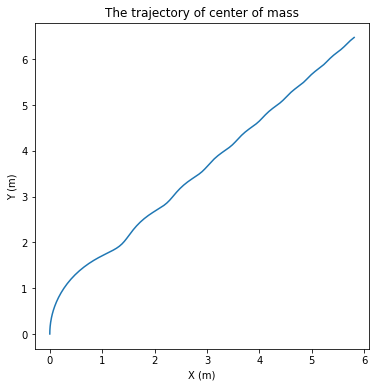

In [5]:
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(dist_x,dist_y)
ax.set(xlabel='X (m)', ylabel='Y (m)',title='The trajectory of center of mass')
plt.savefig("1_3_1.png")

[Text(0.5, 0, 'time'),
 Text(0, 0.5, 'Theta'),
 Text(0.5, 1.0, 'theta changing with time')]

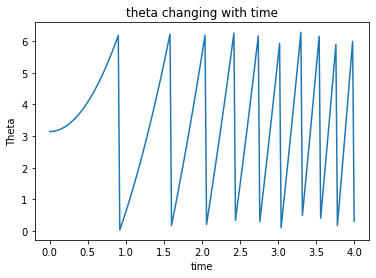

In [6]:
def theta(t,h):
    T = np.arange(0,t+h,h)
    return (6*5*np.sqrt(0.5**2+4/4)*np.sin(np.arctan2(2*0.5,2))/2**2)*T**2
def convert_to_range(theta):
    theta = np.arctan2(np.sin(theta),np.cos(theta))
    # for i in range(len(theta)):
    #     if theta[i] <0:
    #         theta[i] = 2*np.pi-np.abs(theta[i])
    # return theta
    return np.pi+theta
fig, ax = plt.subplots()
ax.plot(t_x,convert_to_range(theta(4,0.02)))
ax.set(xlabel="time",ylabel="Theta",title="theta changing with time")
# plt.savefig("1_3_2.png")

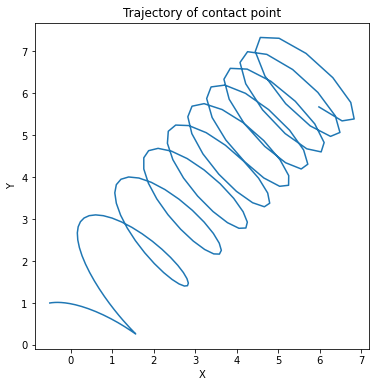

In [7]:
def trajectory(theta, dist_x, dist_y):
    L = 0.5
    D = 2
    X = -L*np.cos(theta) + D/2*np.sin(theta) + dist_x
    Y = -L*np.sin(theta) + D/2*np.cos(theta) + dist_y
    return X,Y
p_x,p_y = trajectory(theta(4,0.02), dist_x, dist_y)
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(p_x,p_y)
ax.set(xlabel="X",ylabel="Y",title="Trajectory of contact point")
plt.savefig("1_3_3.png")

In [8]:
print(dist_x[-1],dist_y[-1])
print(p_x[-1],p_y[-1])

5.806979164419252 6.47741357390244
5.978375033524605 5.677405904038397


## 2.4

In [116]:
npz = np.load("../../datasets/HW0_P1.npz")
A = npz['A']
b = npz['b']
eps = npz['eps']

In [133]:
def NewtonDescent(A,b,eps,lm=0.005,iters=10000):
    m,n = A.shape
    b = b.reshape(-1,1)
    x = np.random.rand(n,1)
    print(A.shape, x.shape, b.shape)
    while(iters):
        if x.T@x<=eps:
            break
        x -= lm*(A.T)@(A@x-b)
        
        iters-=1
    print(x,iters)
    return x
min_x = NewtonDescent(A,b,eps)

(100, 30) (30, 1) (100, 1)
[[ 0.10483454]
 [-0.19582193]
 [-0.09887874]
 [ 0.0277501 ]
 [ 0.18847008]
 [ 0.16294045]
 [-0.16233913]
 [ 0.15986707]
 [ 0.26100913]
 [-0.009287  ]
 [ 0.30889068]
 [ 0.13398261]
 [-0.16518401]
 [-0.06982358]
 [ 0.09298208]
 [ 0.01606512]
 [ 0.15326459]
 [-0.02527857]
 [-0.07426634]
 [ 0.04953601]
 [-0.00129462]
 [ 0.04707387]
 [ 0.01064694]
 [ 0.02830405]
 [ 0.06577829]
 [-0.14191433]
 [ 0.04814367]
 [-0.02489958]
 [ 0.17236578]
 [-0.01664457]] 9983


In [134]:
min_x.T@min_x

array([[0.48912899]])

In [138]:
0.5*np.inner((A@min_x-b).T,(A@min_x-b).T)

array([[11.31158189]])

## 3

In [11]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("use device:",device)

use device: cuda


In [12]:
def pts_loader(path,NUM=1000,MAX_N = 2907):
    # pts_loader provides a load() method to read data from .pts files of
    # point clouds
    #
    # --------------------------------------------------------
    # pts_loader
    # Licensed under The MIT License [see LICENSE.md for details]
    # Copyright (C) 2017 Samuel Albanie 
    # --------------------------------------------------------

    """takes as input the path to a .pts and returns a list of 
	tuples of floats containing the points in in the form:
	[(x_0, y_0, z_0),
	 (x_1, y_1, z_1),
	 ...
	 (x_n, y_n, z_n)]"""
    pts = np.zeros((NUM,MAX_N,3))
    dir_list = os.listdir(path)
    j=0
    for i in dir_list:
        file_path = path+i
        with open(file_path) as f:
            rows = [rows.strip() for rows in f]
        
        coords_set = [point.split() for point in rows]

        """Convert entries from lists of strings to tuples of floats"""
        points = [tuple([float(point) for point in coords]) for coords in coords_set]
        points = np.array(points)
        pts[j,:points.shape[0],:] = points
        j+=1
    return pts


In [13]:
def label_loader(path,MAX_N=2907):
    labels = np.zeros((1000,MAX_N))
    dir_list = os.listdir(path)
    j=0
    for i in dir_list:
        file_path = path+i
        with open(file_path) as f:
            rows = [rows.strip() for rows in f]
            labels[j,:len(rows)]=rows
        j+=1
    return labels

In [14]:
class PointNetSeg(nn.Module):
    def __init__(self,k) -> None:
        super(PointNetSeg,self).__init__()
        self.m = k
        self.conv1 = torch.nn.Conv1d(in_channels = 3, out_channels= 64,kernel_size= 1)
        self.conv21 = torch.nn.Conv1d(64, 128, 1)
        self.conv22 = torch.nn.Conv1d(128, 1024, 1)
        self.conv31 = torch.nn.Conv1d(1088,512,1)
        self.conv32 = torch.nn.Conv1d(512,256,1)
        self.conv33 = torch.nn.Conv1d(256,128,1)
        self.conv4 = torch.nn.Conv1d(128,self.m,1)

        self.bn1 = nn.BatchNorm1d(num_features = 64)
        self.bn21 = nn.BatchNorm1d(128)
        self.bn22 = nn.BatchNorm1d(1024)
        self.bn31 = nn.BatchNorm1d(512)
        self.bn32 = nn.BatchNorm1d(256)
        self.bn33 = nn.BatchNorm1d(128)
    
    def forward(self,x):
        # x shape is batch, channels, num of pts
        batchsize, n_chanel, n_pts = x.size()
        x = F.relu(self.bn1(self.conv1(x)))
        ptsfeats = x
        x = F.relu(self.bn21(self.conv21(x)))
        x = self.bn22(self.conv22(x))
        x = torch.max(x,dim =2,keepdim=True)[0]
        x = x.view(-1,1024,1).repeat(1,1,n_pts)
        x = torch.cat((ptsfeats,x),1)
        x = F.relu(self.bn31(self.conv31(x)))
        x = F.relu(self.bn32(self.conv32(x)))
        x = F.relu(self.bn33(self.conv33(x)))
        x = self.conv4(x)
        x = x.transpose(2,1).contiguous()
        x = F.log_softmax(x.view(-1,self.m),dim=-1)
        x = x.view(batchsize,n_pts,self.m)
        return x
        

In [15]:
batch_size = 250
num_segms = 5 #0,1,2,3,4  (0 is for padding)
learn_rate = 0.001
num_train = 1000
num_test = 6
num_epochs = 20
num_classes = 5
num_batch = int(num_train/batch_size)
n_pts=2907

In [16]:
train_pts_path = '../../datasets/train/pts/'
train_label_path = '../../datasets/train/label/'
test_path = '../../datasets/test/'
train_pts = pts_loader(train_pts_path)
train_labels = label_loader(train_label_path)
train_pts.shape, train_labels.shape #(1000, 2907, 3), (1000, 2907)

((1000, 2907, 3), (1000, 2907))

In [17]:
train_datasets = TensorDataset(torch.Tensor(train_pts),torch.Tensor(train_labels))
train_dataloader = DataLoader(train_datasets,batch_size=batch_size)

In [18]:
pointNetClassifier = PointNetSeg(k=num_classes)
optimizer = optim.Adam(pointNetClassifier.parameters(),lr=learn_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
pointNetClassifier.to(device)

PointNetSeg(
  (conv1): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
  (conv21): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
  (conv22): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
  (conv31): Conv1d(1088, 512, kernel_size=(1,), stride=(1,))
  (conv32): Conv1d(512, 256, kernel_size=(1,), stride=(1,))
  (conv33): Conv1d(256, 128, kernel_size=(1,), stride=(1,))
  (conv4): Conv1d(128, 5, kernel_size=(1,), stride=(1,))
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn21): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn22): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn31): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn32): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn33): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [19]:
temp_preds,temp_target,temp_loss,temp_choice,temp_correct = 0,0,0,0,0

In [20]:
for epoch in range(num_epochs):
    for batch_i, (points,target) in enumerate(train_dataloader,0):
        points = points.transpose(2,1)
        target = target.type(torch.LongTensor)
        points, target = points.to(device), target.to(device)
        target = target.view(-1,1)[:,0]
        optimizer.zero_grad()
        segmenter = pointNetClassifier.train()
        preds = segmenter(points)
        preds = preds.view(-1,num_classes)
        loss = F.nll_loss(preds,target)
        loss.backward()
        optimizer.step()
        pred_choice = preds.data.max(1)[1]
        # pred_choice = preds.max(1)[1]
        # pred_choice = pred_choice.type(torch.LongTensor).contiguous()
        # loss = F.nll_loss(pred_choice.cpu(),target.cpu())
        pred_correct = pred_choice.eq(target.data).cpu().sum()
        print('[epoch {}: {}/{}] train loss: {} accuracy: {}'.format(epoch+1,batch_i+1,num_batch,loss.item(),pred_correct.item()/float(batch_size*n_pts)))
        temp_preds,temp_target,temp_loss,temp_choice,temp_correct = preds,target,loss,pred_choice,pred_correct
    scheduler.step()
        

[epoch 1: 1/4] train loss: 1.7102280855178833 accuracy: 0.1724485724114207
[epoch 1: 2/4] train loss: 1.376878023147583 accuracy: 0.4825208118335053
[epoch 1: 3/4] train loss: 1.141352653503418 accuracy: 0.595296869625043
[epoch 1: 4/4] train loss: 0.9598174095153809 accuracy: 0.7257117303061575
[epoch 2: 1/4] train loss: 0.8643354177474976 accuracy: 0.7679752321981425
[epoch 2: 2/4] train loss: 0.7950428128242493 accuracy: 0.787562435500516
[epoch 2: 3/4] train loss: 0.7384516596794128 accuracy: 0.7954275885792914
[epoch 2: 4/4] train loss: 0.6863488554954529 accuracy: 0.8082518059855521
[epoch 3: 1/4] train loss: 0.6519809365272522 accuracy: 0.8133319573443413
[epoch 3: 2/4] train loss: 0.6195282936096191 accuracy: 0.8241238390092879
[epoch 3: 3/4] train loss: 0.5976731777191162 accuracy: 0.8177860337117303
[epoch 3: 4/4] train loss: 0.5551645755767822 accuracy: 0.8283040935672514
[epoch 4: 1/4] train loss: 0.5337951183319092 accuracy: 0.832656346749226
[epoch 4: 2/4] train loss: 0.5

In [21]:
temp_preds,temp_target,temp_loss,temp_choice,temp_correct

(tensor([[-7.0616, -5.3301, -3.2657, -2.2919, -0.1566],
         [-7.0449, -5.2358, -4.8028, -1.9945, -0.1631],
         [-7.1161, -5.2106, -5.9520, -2.6999, -0.0791],
         ...,
         [-0.0400, -5.9683, -6.1495, -6.8602, -3.3961],
         [-0.0400, -5.9683, -6.1495, -6.8602, -3.3961],
         [-0.0400, -5.9683, -6.1495, -6.8602, -3.3961]], device='cuda:0',
        grad_fn=<ViewBackward0>),
 tensor([4, 4, 4,  ..., 0, 0, 0], device='cuda:0'),
 tensor(0.1607, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor([4, 4, 4,  ..., 0, 0, 0], device='cuda:0'),
 tensor(687804))

In [22]:
def test_loader(path):
    path_list = os.listdir(path)
    pt = []
    for i in path_list:
        with open(path+i) as f:
            rows = [rows.strip() for rows in f]
        coords_set = [point.split() for point in rows]
        points = [tuple([float(point) for point in coords]) for coords in coords_set]
        pt.append(np.array(points))
    return pt
test_path = '../../datasets/test/'
test_pts = test_loader(test_path)

In [23]:
test_path = '../../datasets/test/'
test_pts = pts_loader(test_path,NUM=6,MAX_N=2821)
test_i = test_pts.copy()
test_i = np.transpose(test_i,(0,2,1))
test_i = torch.tensor(test_i)
test_i = test_i.to(device,dtype=torch.float)
segmenter = pointNetClassifier.eval()
pred = segmenter(test_i)
pred_choice = pred.data.max(2)[1]
pred_final = pred_choice.cpu().data.numpy().astype('int')

In [24]:
pred_final.shape, test_pts.shape

((6, 2821), (6, 2821, 3))

In [29]:
red = [1,0,0]
green = [0,1,0]
blue = [0,0,1]
purple = [0.62,0.125,0.94]
white = [1,1,1]
def showopen3d(pts, c):
    pointcloud = o3d.geometry.PointCloud()
    pointcloud.points = o3d.utility.Vector3dVector(pts)
    pointcloud.colors = o3d.utility.Vector3dVector(c)
    o3d.visualization.draw_geometries([pointcloud])
for i in range(pred_final.shape[0]):
    plane = test_pts[i]
    segments = pred_final[i]
    colors = np.zeros(plane.shape)
    for i in range(plane.shape[0]):
        if segments[i] ==0:
            colors[i] = white
        elif segments[i] == 1:
            colors[i] = red
        elif segments[i] == 2:
            colors[i] = green
        elif segments[i] == 3:
            colors[i] = blue
        elif segments[i] == 4:
            colors[i] = purple
    showopen3d(plane,colors)
    

In [26]:
#1-4 indicates arm, back, leg, and seat
#0 padding no color
#1 arm red
#2 back green
#3 leg blue
#4seat purple rgb=0.62,0.125,0.94